# Peak fitting for Scherrer analysis

## Data prep before this step

- perform batch integration on a set of GIWAXS data
- the integrations should all be in the same angular range
- these integrations should be put in a CSV file, where the first column is the q-values and the following columns are the integrations


## Fitting function

- this script fits an isolated peak to $ y = mx + c + Gaussian$
- represented by $y = mx + c + A \cdot e^{-\frac{(x - \mu)^2}{2 \sigma^2}}$
- $x$ and $y$ are q-values and integrated intensities, repsectively (`x`, `y` in the script)
- $m$ and $c$ are linear background (`m`, `c`)
- $A$ is amplitude of Gaussian peak (`A`)
- $\mu$ is mean of Gaussian  (`mu`) 
- $\sigma$ is standard deviation / width of Gaussian  (`sigma`) 
- alternatively, can use Lorentzian fit defined as $L(x) = \frac{A}{\pi \sigma [1+(\frac{\pi - \mu}{\sigma})^2]}$
- in Lorenztian $A$, $\mu$ and $\sigma$ are analogous / similar physical interpretation

In [17]:
### import libraries and modules here ###

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from scipy.optimize import curve_fit
import warnings
from scipy.optimize import OptimizeWarning

In [18]:
### all functions used in script ###

# combined linear + Gaussian function
def linear_gaussian_func(x, m, c, A, mu, sigma):
    linear_part = m * x + c
    gaussian_part = A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))
    return linear_part + gaussian_part

# combined linear + Lorentzian function
def linear_lorentzian_func(x, m, c, A, mu, sigma):
    linear_part = m * x + c
    lorentzian_part = A / (np.pi * sigma * (1 + ((x - mu) / sigma) ** 2))
    return linear_part + lorentzian_part


# def linear_func(x, m, c):
#     return m * x + c

# def gaussian_func(x, A, mu, sigma):
#     return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

In [19]:
# enter filepath and filename 
# remember .csv at the end of filename
#data = pd.read_csv('/home/goughl/Documents/beamtime_data/2409_DLS/SANS_samples/series_int/1D_int_20_60_iso_140_p2mImage1310975.csv')
## out of plane data ##
#data = pd.read_csv('/home/goughl/Documents/beamtime_data/2112_ESRF/MAR/ANDREAS/oct_paper/241029_AEL_IP_180_195.csv')

## in-plane data ##
data = pd.read_csv('/home/goughl/Documents/beamtime_data/2112_ESRF/MAR/ANDREAS/oct_paper/241029_AEL_OoP_250_265.csv')


## minerva ex situ data
#data = pd.read_csv('/home/goughl/Documents/beamtime_data/2409_DLS/for_database/1D_int_DCV4T_HT_0_45_integration_DCV4T_p2mImage_532361_1305575_unnormalised.csv')
#data = pd.read_csv('/home/goughl/Documents/beamtime_data/2409_DLS/for_database/1D_int_DCV4T_HT_45_80_integration_DCV4T_p2mImage_532361_1305575_unnormalised.csv')
#data = pd.read_csv('/home/goughl/Documents/beamtime_data/2409_DLS/for_database/1D_int_PTCDI_HT_50_80_integrated.csv')
#data = pd.read_csv("/home/goughl/Documents/beamtime_data/EA_paper_processing/inplane_toplot.csv")
#data = pd.read_csv("/home/goughl/Documents/beamtime_data/2409_DLS/for_database/1D_EA_RT_15_40_IP_DCV5T_100nm_onEA.csv")


x = data.iloc[2:, 0].values.astype(float)  
y_values = data.iloc[2:, 1:].values.astype(float) 
dataset_labels = data.columns[1:].tolist() 

print(dataset_labels)
# # data should be in following format: first col is x values (the qvalues)
# # following columns contain integrations with one peak isolated
# script can be used with no prior BG removal
# # in csv format!

['RT', '60', '80', '100', '120', '140']


## Important!! 

- only run linear-Gaussian fit OR linear-Lorentzian fit NOT both
- the FWMH and therefore Scherrer calculations will be done on whichever of these cells was run last
- best practice is to comment the one you're not using out so you don't get mixed up

In [20]:
# ### LINEAR GAUSSIAN FIT ###

# # define the min and max x values / q-range for fitting
# # ## for OoP data, use range 0.4 to 1
# # # fit_range_min = 0.4
# # # fit_range_max = 1

# # ## for IP data, use range 1.6 to 1.87
# # fit_range_min = 1.6
# # fit_range_max = 1.87

# # empty list to store parameters for each dataset
# params_list = []

# for i in range(y_values.shape[1]):
#     y = y_values[:, i]

#     # masks data outside defined range
#     fit_mask = (x >= fit_range_min) & (x <= fit_range_max)
#     x_fit = x[fit_mask]
#     y_fit = y[fit_mask]

#     # initial guesses for m, c, A, mu, sigma
#     initial_guess = [1, np.mean(y_fit), max(y_fit), x_fit[np.argmax(y_fit)], 0.1]

#     # Fit the combined model with bounds to enforce positive sigma
#     params, _ = curve_fit(
#         linear_gaussian_func, 
#         x_fit, 
#         y_fit, 
#         p0=initial_guess, 
#         bounds=([-np.inf, -np.inf, -np.inf, -np.inf, 0], np.inf)  # Enforces positive sigma
#     )
    
#     m, c, A, mu, sigma = params

#     # Append the parameters for this dataset to the list
#     params_list.append([dataset_labels[i], m, c, A, mu, sigma])

#     # plotting
#     fitted_model = linear_gaussian_func(x, m, c, A, mu, sigma)
#     residuals = y - fitted_model
#     plt.figure(figsize=(10, 6))
#     plt.subplot(2, 1, 1)
#     plt.plot(x, y, 'b-', label=f'Original data (curve {dataset_labels[i]} °C)')
#     plt.plot(x, fitted_model, 'r-', label=f'Fitted model')
#     plt.axvline(fit_range_min, color='k', linestyle='--')
#     plt.axvline(fit_range_max, color='k', linestyle='--')
#     plt.legend()
    
# # residuals should just be slightly noisy - do this as sanity check     
# #     plt.subplot(2, 1, 2)
# #     plt.plot(x, residuals, 'g-', label='Residuals')
# #     plt.legend()
     
#     plt.show()


In [21]:
# ### LINEAR LORENTZIAN FIT ###

# ## for OoP data, use range 0.4 to 1
# # fit_range_min = 0.4
# # fit_range_max = 1

# ## for IP data, use range 1.6 to 1.87
# fit_range_min = 0.4
# fit_range_max = 1

# params_list = []

# for i in range(y_values.shape[1]):
#     y = y_values[:, i]

#     fit_mask = (x >= fit_range_min) & (x <= fit_range_max)
#     x_fit = x[fit_mask]
#     y_fit = y[fit_mask]

#     # initial guesses for m, c, A, mu, sigma
#     initial_guess = [
#         1,                   # slope m
#         np.mean(y_fit),      # intercept c
#         max(y_fit),          # amplitude A
#         x_fit[np.argmax(y_fit)],  # center mu
#         0.1                  # width sigma (positive)
#     ]

#     try:
#         params, _ = curve_fit(
#             linear_lorentzian_func, 
#             x_fit, 
#             y_fit, 
#             p0=initial_guess, 
#             bounds=([-np.inf, -np.inf, -np.inf, fit_range_min, 0], [np.inf, np.inf, np.inf, fit_range_max, np.inf])
#         )
        
#         m, c, A, mu, sigma = params
#         params_list.append([dataset_labels[i], m, c, A, mu, sigma])

#         fitted_model = linear_lorentzian_func(x, m, c, A, mu, sigma)
#         residuals = y - fitted_model
        
#         plt.figure(figsize=(10, 6))
        
#         plt.subplot(2, 1, 1)
#         plt.plot(x, y, 'b-', label=f'Original data (curve {dataset_labels[i]} °C)')
#         plt.plot(x, fitted_model, 'r-', label=f'Fitted model')
#         plt.axvline(fit_range_min, color='k', linestyle='--')
#         plt.axvline(fit_range_max, color='k', linestyle='--')
#         plt.title('Linear-Lorentzian fit')
#         plt.legend()
        
# #         plt.subplot(2, 1, 2)
# #         plt.plot(x, residuals, 'g-', label='Residuals')
# #         plt.legend()

#         plt.show()
        
#     except RuntimeError as e:
#         print(f"Fit did not converge for dataset {dataset_labels[i]}: {e}")


In [22]:
#params_df = pd.DataFrame(params_list, columns=['Dataset', 'm', 'c', 'A', 'mu', 'sigma'])

## Linear-Lorentzian fit with errors

- the `curve_fit` function returns the fitted parameters and also the covariance matrix
- the square root of the diagonal elements of the covariance matrix gives the standard errors of the fitted parameters
- for sigma, the error is $\Delta \sigma = \sqrt{Cov (\sigma,\sigma)}$
- for the FWHM, the error is $\Delta FWHM = 2.355 \cdot \Delta \sigma$

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

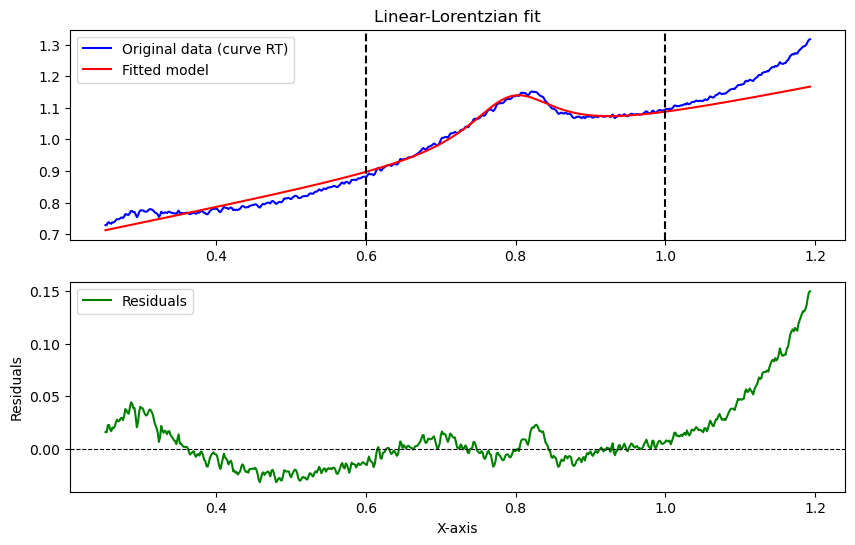

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

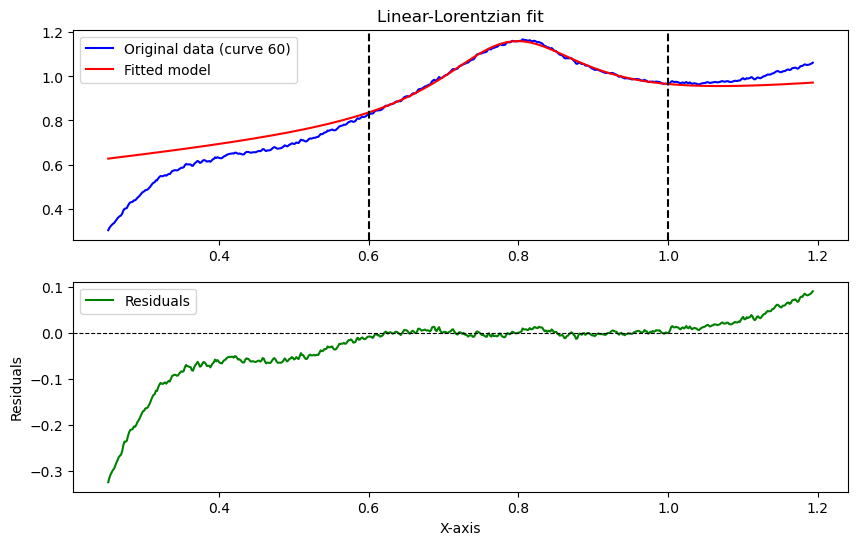

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

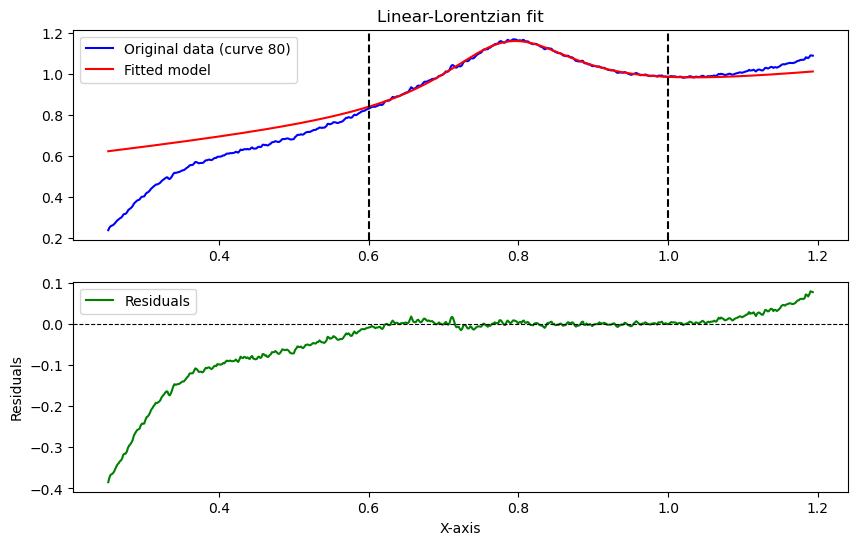

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

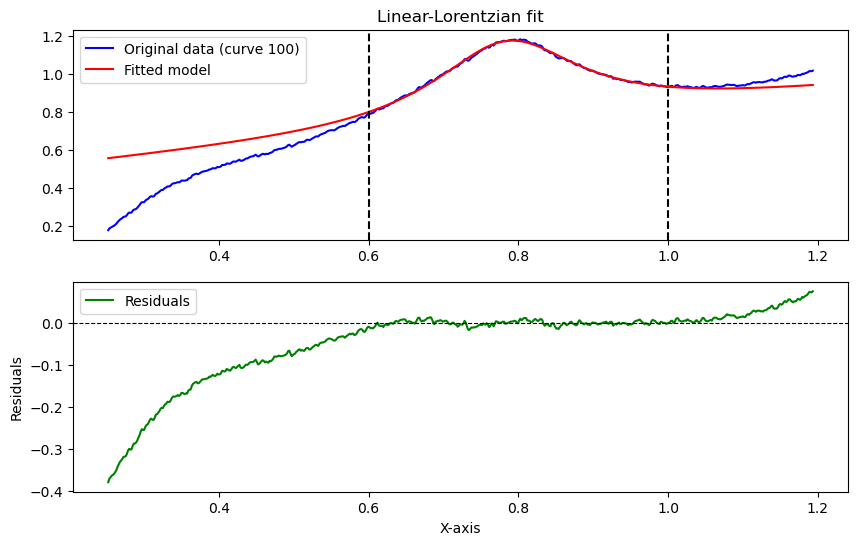

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

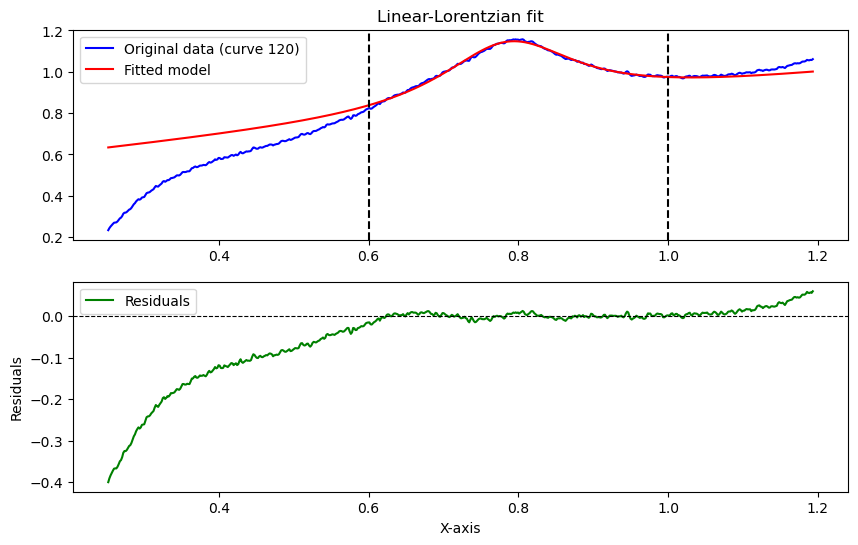

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

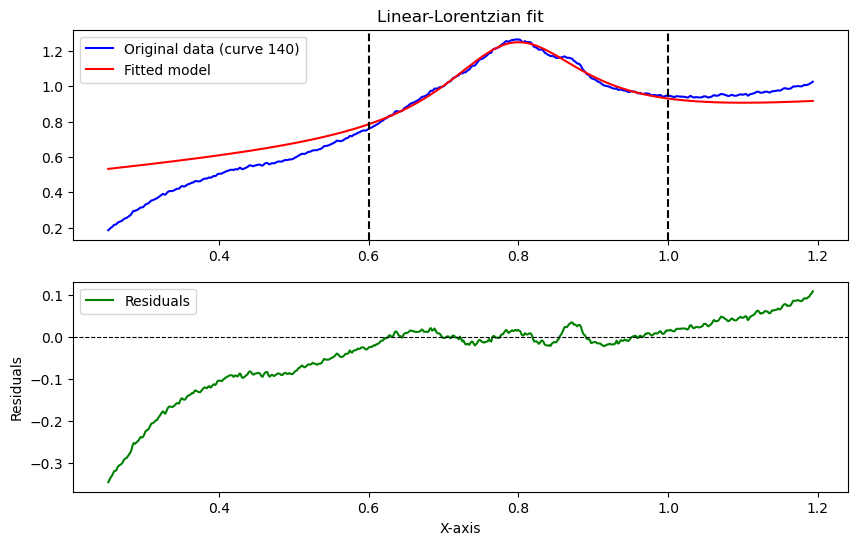

In [31]:
### LINEAR LORENTZIAN FIT  WITH ERRORS ###

fit_range_min = 0.6
fit_range_max = 1

params_list_with_fwhm_and_errors = []  

for i in range(y_values.shape[1]):
    y = y_values[:, i]

    fit_mask = (x >= fit_range_min) & (x <= fit_range_max)
    x_fit = x[fit_mask]
    y_fit = y[fit_mask]

    initial_guess = [
        1,                   # slope m
        np.mean(y_fit),      # intercept c
        max(y_fit),          # amplitude A
        x_fit[np.argmax(y_fit)],  # center mu
        0.1                  # width sigma (positive)
    ]

    try:
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore", OptimizeWarning)
            params, covariance = curve_fit(
                linear_lorentzian_func, 
                x_fit, 
                y_fit, 
                p0=initial_guess, 
                bounds=([-np.inf, -np.inf, -np.inf, fit_range_min, 0], [np.inf, np.inf, np.inf, fit_range_max, np.inf])
            )
        

        m, c, A, mu, sigma = params
        errors = np.sqrt(np.diag(covariance)) 
        sigma_error = errors[4] 


        fwhm = 2.355 * sigma
        fwhm_error = 2.355 * sigma_error

        params_list_with_fwhm_and_errors.append([dataset_labels[i], m, c, A, mu, sigma, fwhm, sigma_error, fwhm_error])


        fitted_model = linear_lorentzian_func(x, m, c, A, mu, sigma)
        residuals = y - fitted_model
        
        plt.figure(figsize=(10, 6))
        
        plt.subplot(2, 1, 1)
        plt.plot(x, y, 'b-', label=f'Original data (curve {dataset_labels[i]})')
        plt.plot(x, fitted_model, 'r-', label=f'Fitted model')
        plt.axvline(fit_range_min, color='k', linestyle='--')
        plt.axvline(fit_range_max, color='k', linestyle='--')
        plt.title('Linear-Lorentzian fit')
        plt.legend()
        
        plt.subplot(2, 1, 2)
        plt.plot(x, residuals, 'g-', label='Residuals')
        plt.axhline(0, color='k', linestyle='--', linewidth=0.8)
        plt.xlabel('X-axis')
        plt.ylabel('Residuals')
        plt.legend()

        plt.show()
        
    except (RuntimeError, ValueError) as e:
        print(f"Fit did not converge for dataset {dataset_labels[i]}: {e}")

params_df = pd.DataFrame(
    params_list_with_fwhm_and_errors, 
    columns=['Dataset', 'm', 'c', 'A', 'mu', 'sigma', 'FWHM', 'sigma_error', 'FWHM_error']
)


In [24]:
print(params_df)

  Dataset         m         c         A        mu     sigma      FWHM  \
0      RT  0.511943  0.550096  0.046315  0.793082  0.083387  0.196376   
1      60  0.421271  0.407967  0.188544  0.786920  0.145924  0.343650   
2      80  0.492711  0.358944  0.188623  0.781376  0.149297  0.351596   
3     100  0.504525  0.256269  0.243152  0.778691  0.151980  0.357912   
4     120  0.498796  0.331155  0.201794  0.777892  0.156424  0.368380   
5     140  0.490704  0.244690  0.266855  0.790432  0.140961  0.331964   

   sigma_error  FWHM_error  
0     0.001682    0.003961  
1     0.001584    0.003729  
2     0.001865    0.004392  
3     0.001699    0.004001  
4     0.002301    0.005418  
5     0.001834    0.004319  


## FWMH calculation


- Cell below calculates full width at half maximum (`fwhm`) using: $FWHM = 2\sqrt{2 ln(2)} \cdot \sigma \approx 2.355 \sigma $ 

In [ ]:
### loops through calculated params and finds FWHM based on above formula using standard deviation sigma ###
params_list_with_fwhm = []

for params in params_list:
    dataset_label, m, c, A, mu, sigma = params
    fwhm = 2.355 * sigma  # FWHM calculation
    params_list_with_fwhm.append([dataset_label, m, c, A, mu, sigma, fwhm])


params_df = pd.DataFrame(params_list_with_fwhm, columns=['Dataset', 'm', 'c', 'A', 'mu', 'sigma', 'FWHM'])
print(params_df)

## Scherrer equation calculation

- cell below calculates crystallite coherence length $D_{hkl}$ (`D`) using the Scherrer equation
- Scherrer equation is: $D_{hkl} = \frac{2\pi K}{ \Delta q_{hkl}}$
- $K$ is the Scherrer constant, assume to be 1 (`K`)
- $\Delta q_{hkl}$ is the FWHM of the diffraction peaks (`fwhm`)

In [ ]:
### calculating coherence length of crystallites in nm ###

K = 1  # Scherrer constant, assume to be 1

params_df['D'] = (2 * np.pi * K) / params_df['FWHM'] / 10
# division by 10 here is to convert from Angstrom to nanometers

print(params_df[['Dataset', 'D']])

In [ ]:
# ### plotting coherence length as a function of some variable ###

# plt.figure(figsize=(10, 6))
# x_values = np.arange(len(params_df))
# plt.plot(x_values, params_df['D'], marker='x', linestyle='-', color='r', label='D (nm)')


# plt.xticks(x_values, params_df['Dataset'].values, rotation=45) 


# plt.xlabel('Temperature (°C)')
# plt.ylabel('D (nm)')
# plt.title('Coherence length as a function of temp')
# plt.axhline(1.75, color='gray', lw=0.5, linestyle='--')  # first argument makes baseline y = arg (i.e. horiz line)
# plt.grid()
# plt.legend()
# plt.tight_layout()
# plt.show()


In [29]:
## SPECIAL CASE WHERE TWO PEAKS OVERLAP ###


def linear_double_lorentzian_func(x, m, c, A1, mu1, gamma1, A2, mu2, gamma2):
    linear_part = m * x + c
    lorentzian1 = A1 * gamma1**2 / ((x - mu1)**2 + gamma1**2)
    lorentzian2 = A2 * gamma2**2 / ((x - mu2)**2 + gamma2**2)
    return linear_part + lorentzian1 + lorentzian2

def fit_double_lorentzian(data, x, label):

    if label not in params_df['Dataset'].values:
        print(f"Dataset label '{label}' not found.")
        return

    label_index = params_df[params_df['Dataset'] == label].index[0]
    y = y_values[:, label_index]


    fit_mask = (x >= fit_range_min) & (x <= fit_range_max)
    x_fit = x[fit_mask]
    y_fit = y[fit_mask]

    # initial guesses, enter numbers based on visual inspection
    initial_guess = [
        1,                # slope (m) of the linear background
        np.mean(y_fit),   # intercept (c) of the linear background
        max(y_fit) / 2,   # amplitude of first Lorentzian (A1)
        1.25,             # center of first Lorentzian (mu1)
        0.07,             # width of first Lorentzian (gamma1)
        max(y_fit) / 2,   # amplitude of second Lorentzian (A2)
        1.45,             # center of second Lorentzian (mu2)
        0.02              # width of second Lorentzian (gamma2)
    ]

    params, _ = curve_fit(linear_double_lorentzian_func, x_fit, y_fit, p0=initial_guess)
    m, c, A1, mu1, gamma1, A2, mu2, gamma2 = params

    plt.figure(figsize=(10, 6))
    plt.plot(x, y, 'b-', label=f'Original data ({label})°C')

    combined_fit = linear_double_lorentzian_func(x, m, c, A1, mu1, gamma1, A2, mu2, gamma2)
    plt.plot(x, combined_fit, 'r-', label='Double Lorentzian fit')

    linear_part = m * x + c
    plt.plot(x, linear_part, 'k--', label='Linear component')

    lorentzian1 = A1 * gamma1**2 / ((x - mu1)**2 + gamma1**2)
    lorentzian2 = A2 * gamma2**2 / ((x - mu2)**2 + gamma2**2)
    plt.plot(x, lorentzian1 + linear_part, 'g--', label='Lorentzian 1')
    plt.plot(x, lorentzian2 + linear_part, 'm--', label='Lorentzian 2')

    plt.xlabel('q-values')
    plt.ylabel('Intensity')
    plt.title(f'Double Lorentzian Fit for {label}')
    plt.legend()
    plt.show()

    fwhm1 = 2 * abs(gamma1)
    fwhm2 = 2 * abs(gamma2)
    print(f"FWHM for Lorentzian 1: {fwhm1}")
    print(f"peak centre for lor1 is {mu1} ± {gamma1}")
    print(f"FWHM for Lorentzian 2: {fwhm2}")
    print(f"peak centre for lor2 is {mu2} ± {gamma2}")

fit_double_lorentzian(data, x, 'RT')


RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1800.

In [ ]:
# # not essential for calculating FWHM 
# # plots both parts of fit - the linear part and the isolated Gaussian
# # this is to check it looks sensible

# # loop through each dataset to plot the original data, combined fit, linear, and Gaussian parts
# for i in range(y_values.shape[1]):
#     y = y_values[:, i]
    
#     # retrieve parameters from the DataFrame
#     m = params_df.loc[i, 'm']
#     c = params_df.loc[i, 'c']
#     A = params_df.loc[i, 'A']
#     mu = params_df.loc[i, 'mu']
#     sigma = params_df.loc[i, 'sigma']
    
#     # calculate indiviual components
#     linear_component = m * x + c # linear
#     gaussian_component = A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2)) # Gaussian
#     combined_fit = linear_component + gaussian_component  # linear + Gaussian

#     plt.figure(figsize=(12, 8))

#     # plot 1: original data with combined fit
#     plt.subplot(4, 1, 1)
#     plt.plot(x, y, 'b-', label=f'Original Data ({dataset_labels[i]} °C)')
#     plt.plot(x, combined_fit, 'r--', label='Combined Fit (Linear + Gaussian)')
#     plt.axvline(fit_range_min, color='k', linestyle='--', label='Fit range')
#     plt.axvline(fit_range_max, color='k', linestyle='--')
#     plt.title(f'{dataset_labels[i]} °C data')
#     plt.legend()

#     # plot 2: linear component only
#     plt.subplot(4, 1, 2)
#     plt.plot(x, linear_component, 'g-', label='Linear Component (y = mx + c)')
#     plt.legend()


#     # plot 3: Gaussian component only
#     plt.subplot(4, 1, 3)
#     plt.plot(x, gaussian_component, 'm-', label=f'Gaussian Component for {dataset_labels[i]} °C sample')
#     plt.legend()

# #     # plot 4: Original data minus linear component (isolated Gaussian data)
# #     plt.subplot(4, 1, 4)
# #     plt.plot(x, y - linear_component, 'b-', label='Isolated Gaussian Data')
# #     plt.plot(x, gaussian_component, 'r--', label='Fitted Gaussian')
# #     plt.legend()

#     plt.xlabel('x')
#     plt.ylabel('Intensity')
#     plt.tight_layout()
#     plt.show()


In [32]:
def linear_double_lorentzian_func(x, m, c, A1, mu1, gamma1, A2, mu2, gamma2):
    linear_part = m * x + c
    lorentzian1 = A1 * gamma1**2 / ((x - mu1)**2 + gamma1**2)
    lorentzian2 = A2 * gamma2**2 / ((x - mu2)**2 + gamma2**2)
    return linear_part + lorentzian1 + lorentzian2

def fit_double_lorentzian(data, x, label):
    # Ensure the label exists
    if label not in params_df['Dataset'].values:
        print(f"Dataset label '{label}' not found.")
        return

    # Retrieve the y-values for the given label
    label_index = params_df[params_df['Dataset'] == label].index[0]
    y = y_values[:, label_index]

    # Define fitting range
    fit_mask = (x >= fit_range_min) & (x <= fit_range_max)
    x_fit = x[fit_mask]
    y_fit = y[fit_mask]

    # Initial guesses for the parameters
    initial_guess = [
        1,                # slope (m) of the linear background
        np.mean(y_fit),   # intercept (c) of the linear background
        max(y_fit) / 2,   # amplitude of first Lorentzian (A1)
        0.79,             # center of first Lorentzian (mu1)
        0.07,             # width of first Lorentzian (gamma1)
        max(y_fit) / 2,   # amplitude of second Lorentzian (A2)
        0.87,             # center of second Lorentzian (mu2)
        0.02              # width of second Lorentzian (gamma2)
    ]

    try:
        # Perform the curve fitting
        params, covariance = curve_fit(
            linear_double_lorentzian_func, 
            x_fit, 
            y_fit, 
            p0=initial_guess
        )
        m, c, A1, mu1, gamma1, A2, mu2, gamma2 = params

        # Plot the results
        plt.figure(figsize=(10, 6))
        plt.plot(x, y, 'b-', label=f'Original data ({label})°C')

        combined_fit = linear_double_lorentzian_func(x, m, c, A1, mu1, gamma1, A2, mu2, gamma2)
        plt.plot(x, combined_fit, 'r-', label='Double Lorentzian fit')

        linear_part = m * x + c
        plt.plot(x, linear_part, 'k--', label='Linear component')

        lorentzian1 = A1 * gamma1**2 / ((x - mu1)**2 + gamma1**2)
        lorentzian2 = A2 * gamma2**2 / ((x - mu2)**2 + gamma2**2)
        plt.plot(x, lorentzian1 + linear_part, 'g--', label='Lorentzian 1')
        plt.plot(x, lorentzian2 + linear_part, 'm--', label='Lorentzian 2')

        plt.xlabel('q-values')
        plt.ylabel('Intensity')
        plt.title(f'Double Lorentzian Fit for {label}')
        plt.legend()
        plt.show()

        # Calculate FWHMs and errors
        fwhm1 = 2 * abs(gamma1)
        fwhm2 = 2 * abs(gamma2)

        if covariance is not None:
            errors = np.sqrt(np.diag(covariance))  # Standard errors from covariance matrix
            gamma1_error = errors[4]  # Error in gamma1
            gamma2_error = errors[7]  # Error in gamma2
            fwhm1_error = 2 * gamma1_error
            fwhm2_error = 2 * gamma2_error

            print(f"FWHM for Lorentzian 1: {fwhm1} ± {fwhm1_error}")
            print(f"Peak center for Lorentzian 1: {mu1} ± {errors[3]}")
            print(f"FWHM for Lorentzian 2: {fwhm2} ± {fwhm2_error}")
            print(f"Peak center for Lorentzian 2: {mu2} ± {errors[6]}")
        else:
            print(f"FWHM for Lorentzian 1: {fwhm1}")
            print(f"Peak center for Lorentzian 1: {mu1}")
            print(f"FWHM for Lorentzian 2: {fwhm2}")
            print(f"Peak center for Lorentzian 2: {mu2}")

    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")


findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

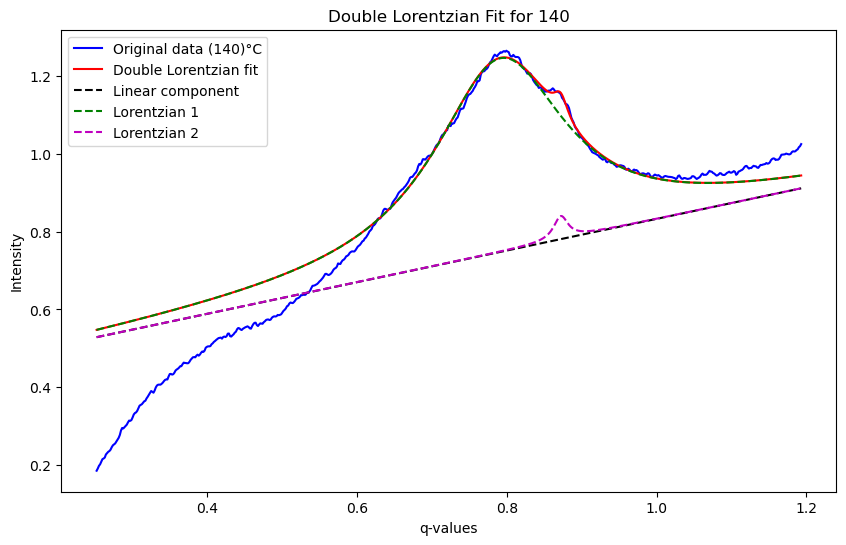

FWHM for Lorentzian 1: 0.2138426965223484 ± 0.0038983666224011245
Peak center for Lorentzian 1: 0.791367552782405 ± 0.0007126908731881533
FWHM for Lorentzian 2: 0.023683173003451043 ± 0.0038683671658871943
Peak center for Lorentzian 2: 0.8722403363648891 ± 0.0008861877102769761


In [33]:
fit_double_lorentzian(data, x, '140')